# Testing results against Scikit-learn and Autograd

## Scikit Learn

### Imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor


# --- Our own code ---
import importlib, Implementations.prepare_data, Implementations.neural_network
importlib.reload(Implementations.prepare_data)
importlib.reload(Implementations.neural_network)
from Implementations.neural_network import NeuralNetwork
from Implementations.optimizers import SGD, RMSprop, Adam
from Implementations.losses import mse, mse_deriv
from Implementations.activations import sigmoid, sigmoid_deriv, linear, linear_deriv, relu, relu_deriv
from Implementations.prepare_data import prepare_data

## Plot styling

In [2]:
import matplotlib
from cycler import cycler

# ---------- Updated palette with clearer separation ----------
economist_palette = [
    "#E3120B",  # strong red
    "#0096FF",  # bright blue
    "#FFC107",  # yellow
    "#007A3D",  # green
    "#FF6F00",  # orange
    "#6E6E6E",  # medium gray
    "#6A1B9A",  # purple
    "#40C4FF",  # light sky blue
    "#005566",  # deep teal
    "#A10000",  # dark red
]

matplotlib.rcParams.update({
    # ----------- Font & text -----------
    "font.family": "serif",
    "font.serif": ["DejaVu Serif"],
    "font.size": 22,
    "axes.labelsize": 18,
    "axes.titlesize": 26,          # large titles (good after LaTeX shrink)
    "axes.titleweight": "bold",
    "axes.titlelocation": "center",
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,

    # ----------- Figure quality --------
    "figure.figsize": (12, 8),      # safe even when LaTeX squeezes to 1 column
    "figure.dpi": 300,
    "savefig.dpi": 450,
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.03,

    # ----------- Line style ------------
    "lines.linewidth": 3.0,
    "lines.markersize": 8,

    # ----------- Grid & axes -----------
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.linewidth": 0.8,
    "grid.alpha": 0.40,
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2,
    "figure.facecolor": "white",
    "axes.facecolor": "white",

    # ----------- Ticks -----------------
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 5,
    "ytick.major.size": 5,

    # ----------- Legend ----------------
    "legend.frameon": False,

    # ----------- Color cycle -----------
    "axes.prop_cycle": cycler(color=economist_palette),
})


### Prepare data

In [3]:
seed = 6114
n_datapoints = 100
x, y, x_train, x_test, y_train, y_test = prepare_data(n=n_datapoints)

scaler_x = StandardScaler()
x_train = scaler_x.fit_transform(x_train)
x_test = scaler_x.transform(x_test)

batch_size_adam = 32
lr = 1e-2
epochs = 500

### Build network with Scikit Learn

In [4]:
layers =[50, 50]
nn_sklearn = MLPRegressor(loss='squared_error', 
                          hidden_layer_sizes=layers, 
                          activation='logistic',
                          solver='adam',
                          alpha = 0,
                          batch_size=batch_size_adam,
                          learning_rate_init=lr,
                          max_iter=epochs,
                          random_state=seed)

nn_sklearn.fit(x_train, y_train.ravel())
weights = nn_sklearn.coefs_
biases = nn_sklearn.intercepts_



### Building network with our own code

In [5]:
layer_output_sizes = [50, 50,1]
activation_funcs = [sigmoid, sigmoid, linear]
activation_ders = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
cost_func = mse
cost_func_der = mse_deriv

nn_own = NeuralNetwork(network_input_size=1, 
                   layer_output_sizes=layer_output_sizes, 
                   activation_funcs=activation_funcs,
                   activation_ders=activation_ders,
                   cost_fun=cost_func,
                   cost_der=cost_func_der,
                   seed = seed)

lr = 1e-2
optimizer = Adam(lr=lr)
history = nn_own.fit(x_train, 
                 y_train,
                 epochs=epochs,
                 batch_size=32,
                 optimizer=optimizer,
                 log_every=None)






### Comparison: 

Note: Since the weights and biases are initialized differently in my implementation and in ScikitLearn, and since the optimizer most likely has a different implementation, we cannot expect the biases and weight to be equal. (Different combination of weights and biases can lead to similar predictions). Instead, we will compare the predictions made by our network with the predictions made by the scikit learn network

In [6]:
### Making predictions with the networks:
y_pred_test_own = nn_own.predict(x_test)
y_pred_test_sklearn = nn_sklearn.predict(x_test).reshape(-1, 1)

diff = y_pred_test_own - y_pred_test_sklearn


l2_norm = np.linalg.norm(diff)
l_inf_norm = np.max(np.abs(diff))
mean_abs_diff = np.mean(np.abs(diff))

print(f"L2-norm difference: {l2_norm:.3e}")
print(f"Max abs difference: {l_inf_norm:.3e}")
print(f"Mean abs difference: {mean_abs_diff:.3e}")


L2-norm difference: 1.180e+00
Max abs difference: 7.437e-01
Mean abs difference: 1.980e-01


### Parity plot for these predictions

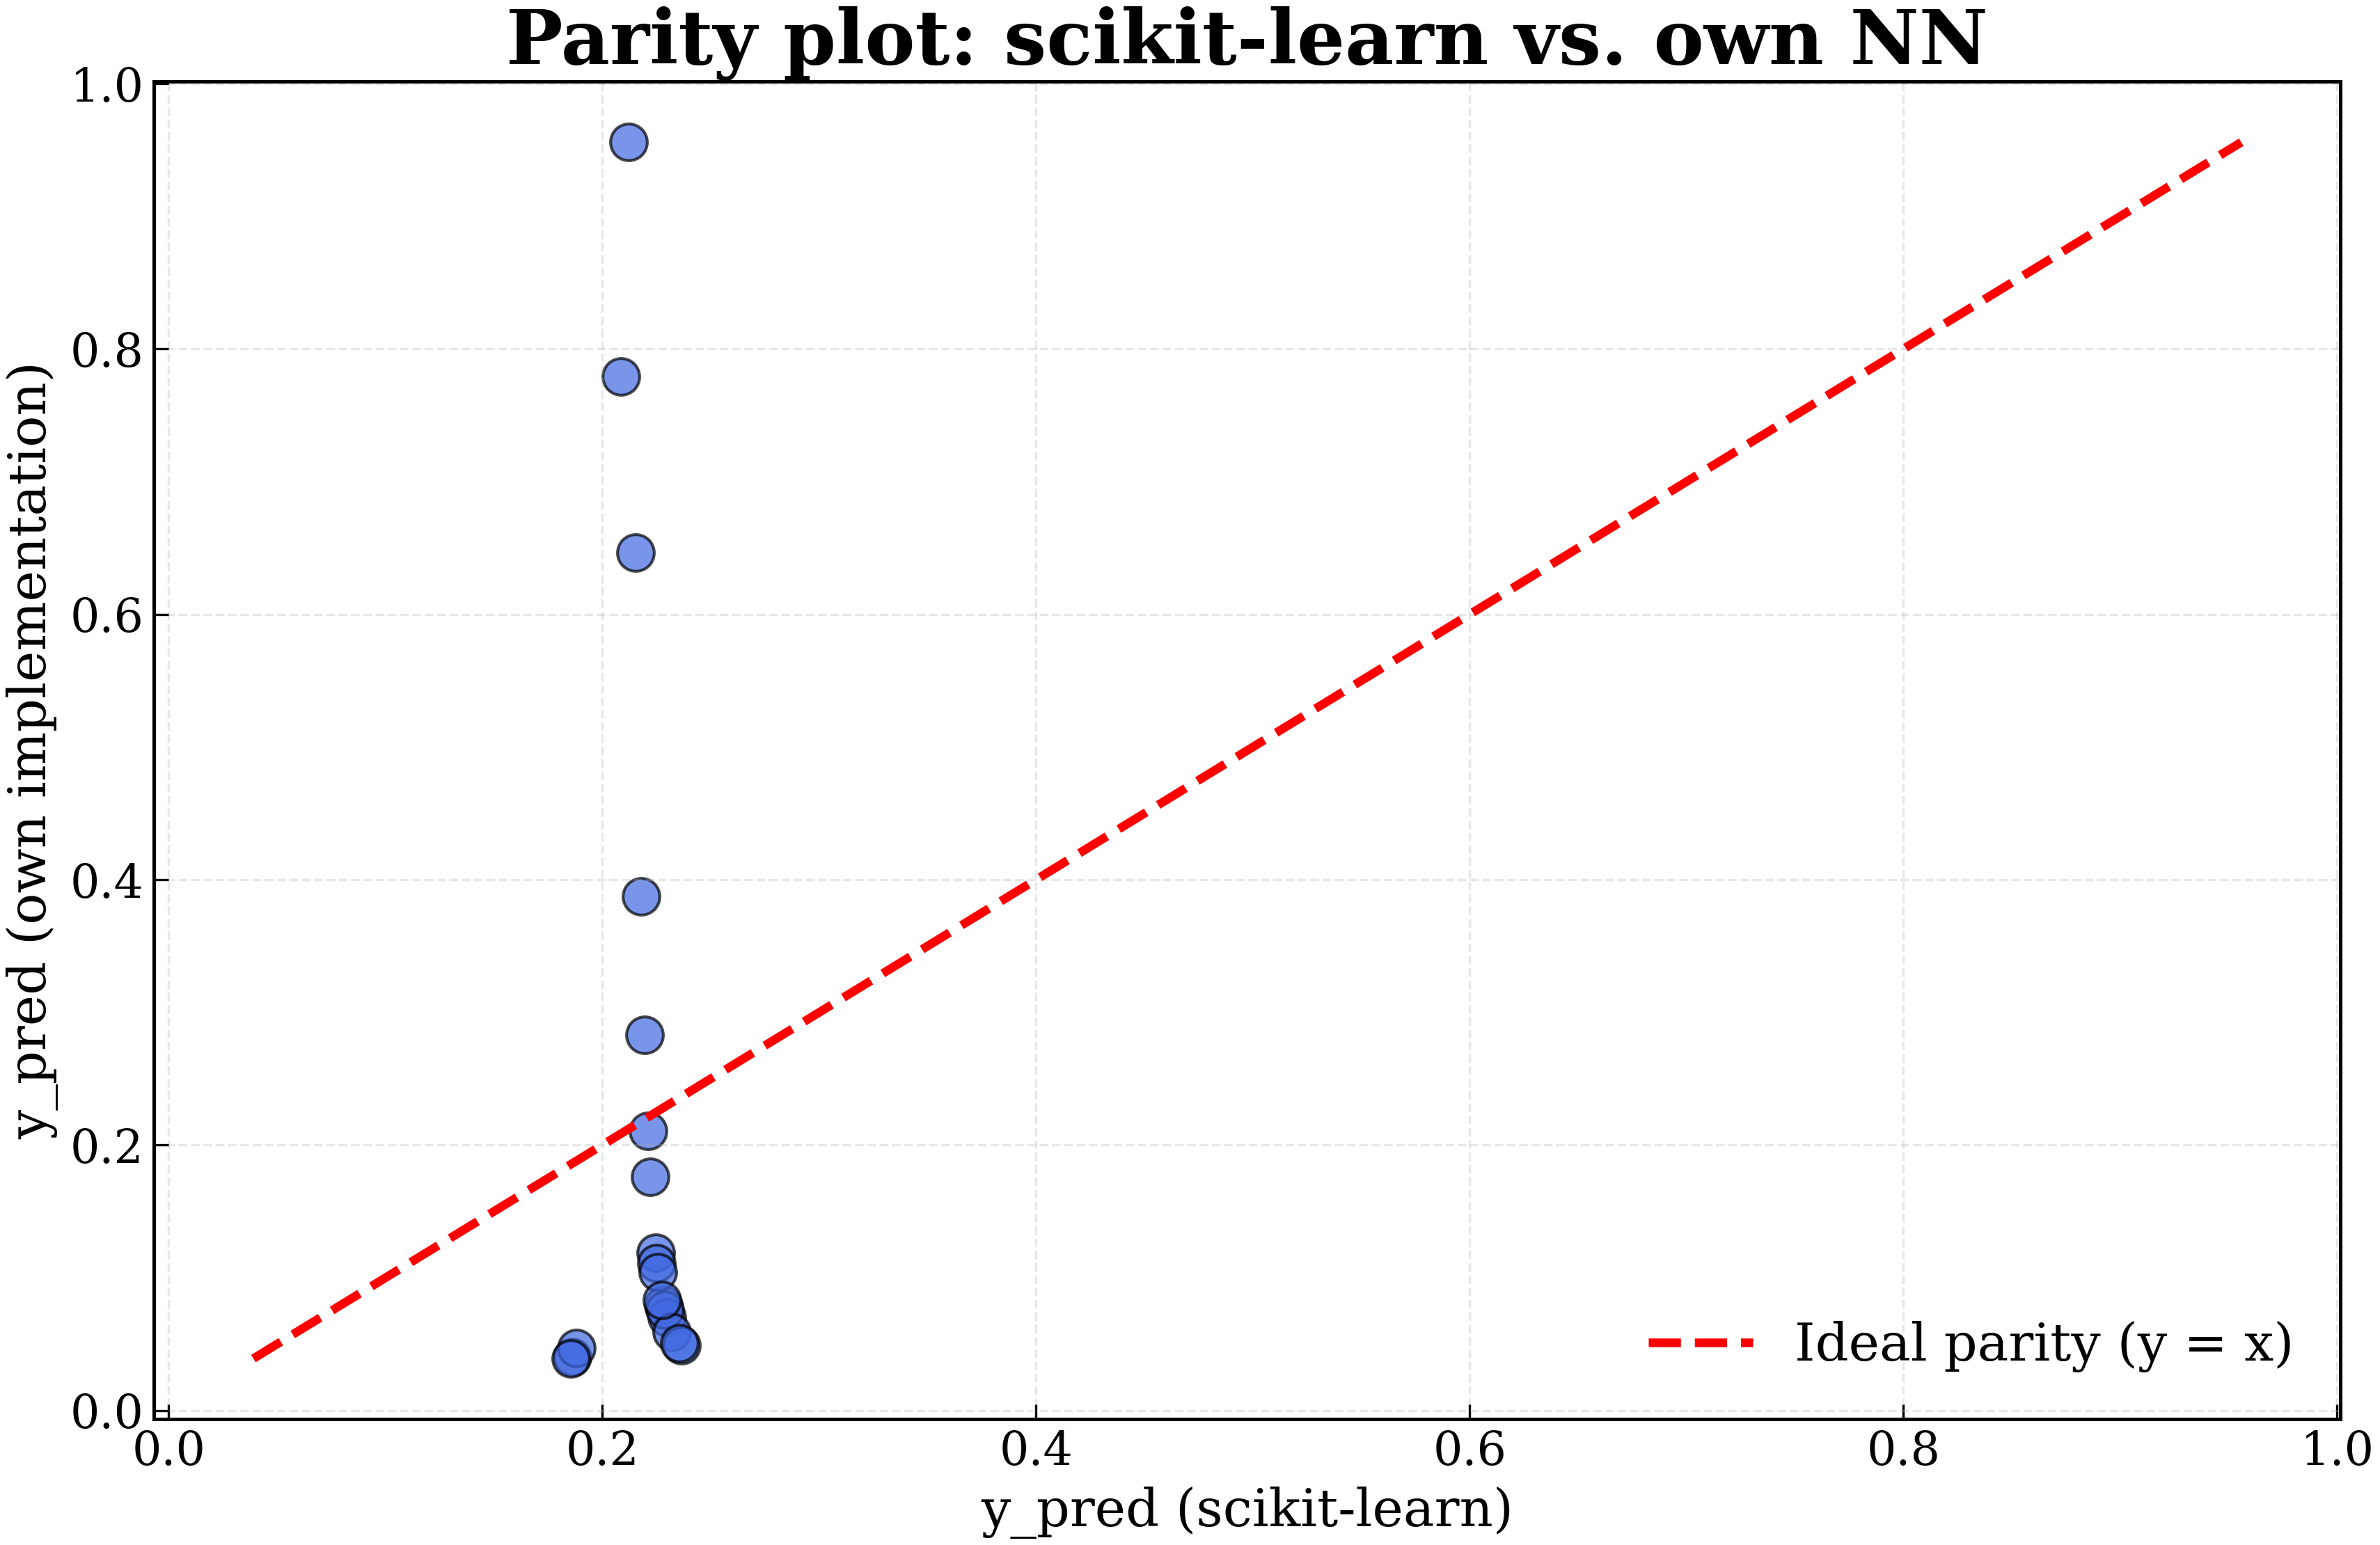

In [7]:
# Make arrays 1d
y_own = y_pred_test_own.ravel()
y_sk  = y_pred_test_sklearn.ravel()

# Make parity-plot
# plt.figure(figsize=(12,6))
plt.scatter(y_sk, y_own, s=160, alpha=0.7, color='royalblue', edgecolor='k')
min_val = min(np.min(y_sk), np.min(y_own))
max_val = max(np.max(y_sk), np.max(y_own))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal parity (y = x)')
plt.xlabel("y_pred (scikit-learn)")
plt.ylabel("y_pred (own implementation)")
plt.title("Parity plot: scikit-learn vs. own NN")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()

# run by itself then comment out
# plt.savefig("../Plots/Exc_parity_plot_scikit_nn.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Optional: histogram of differences
# plt.figure(figsize=(6,3))
# plt.hist(y_own - y_sk, bins=30, color='gray', edgecolor='black')
# plt.title("Histogram of prediction differences (own - sklearn)")
# plt.xlabel("Δŷ")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()


### How the predictions look

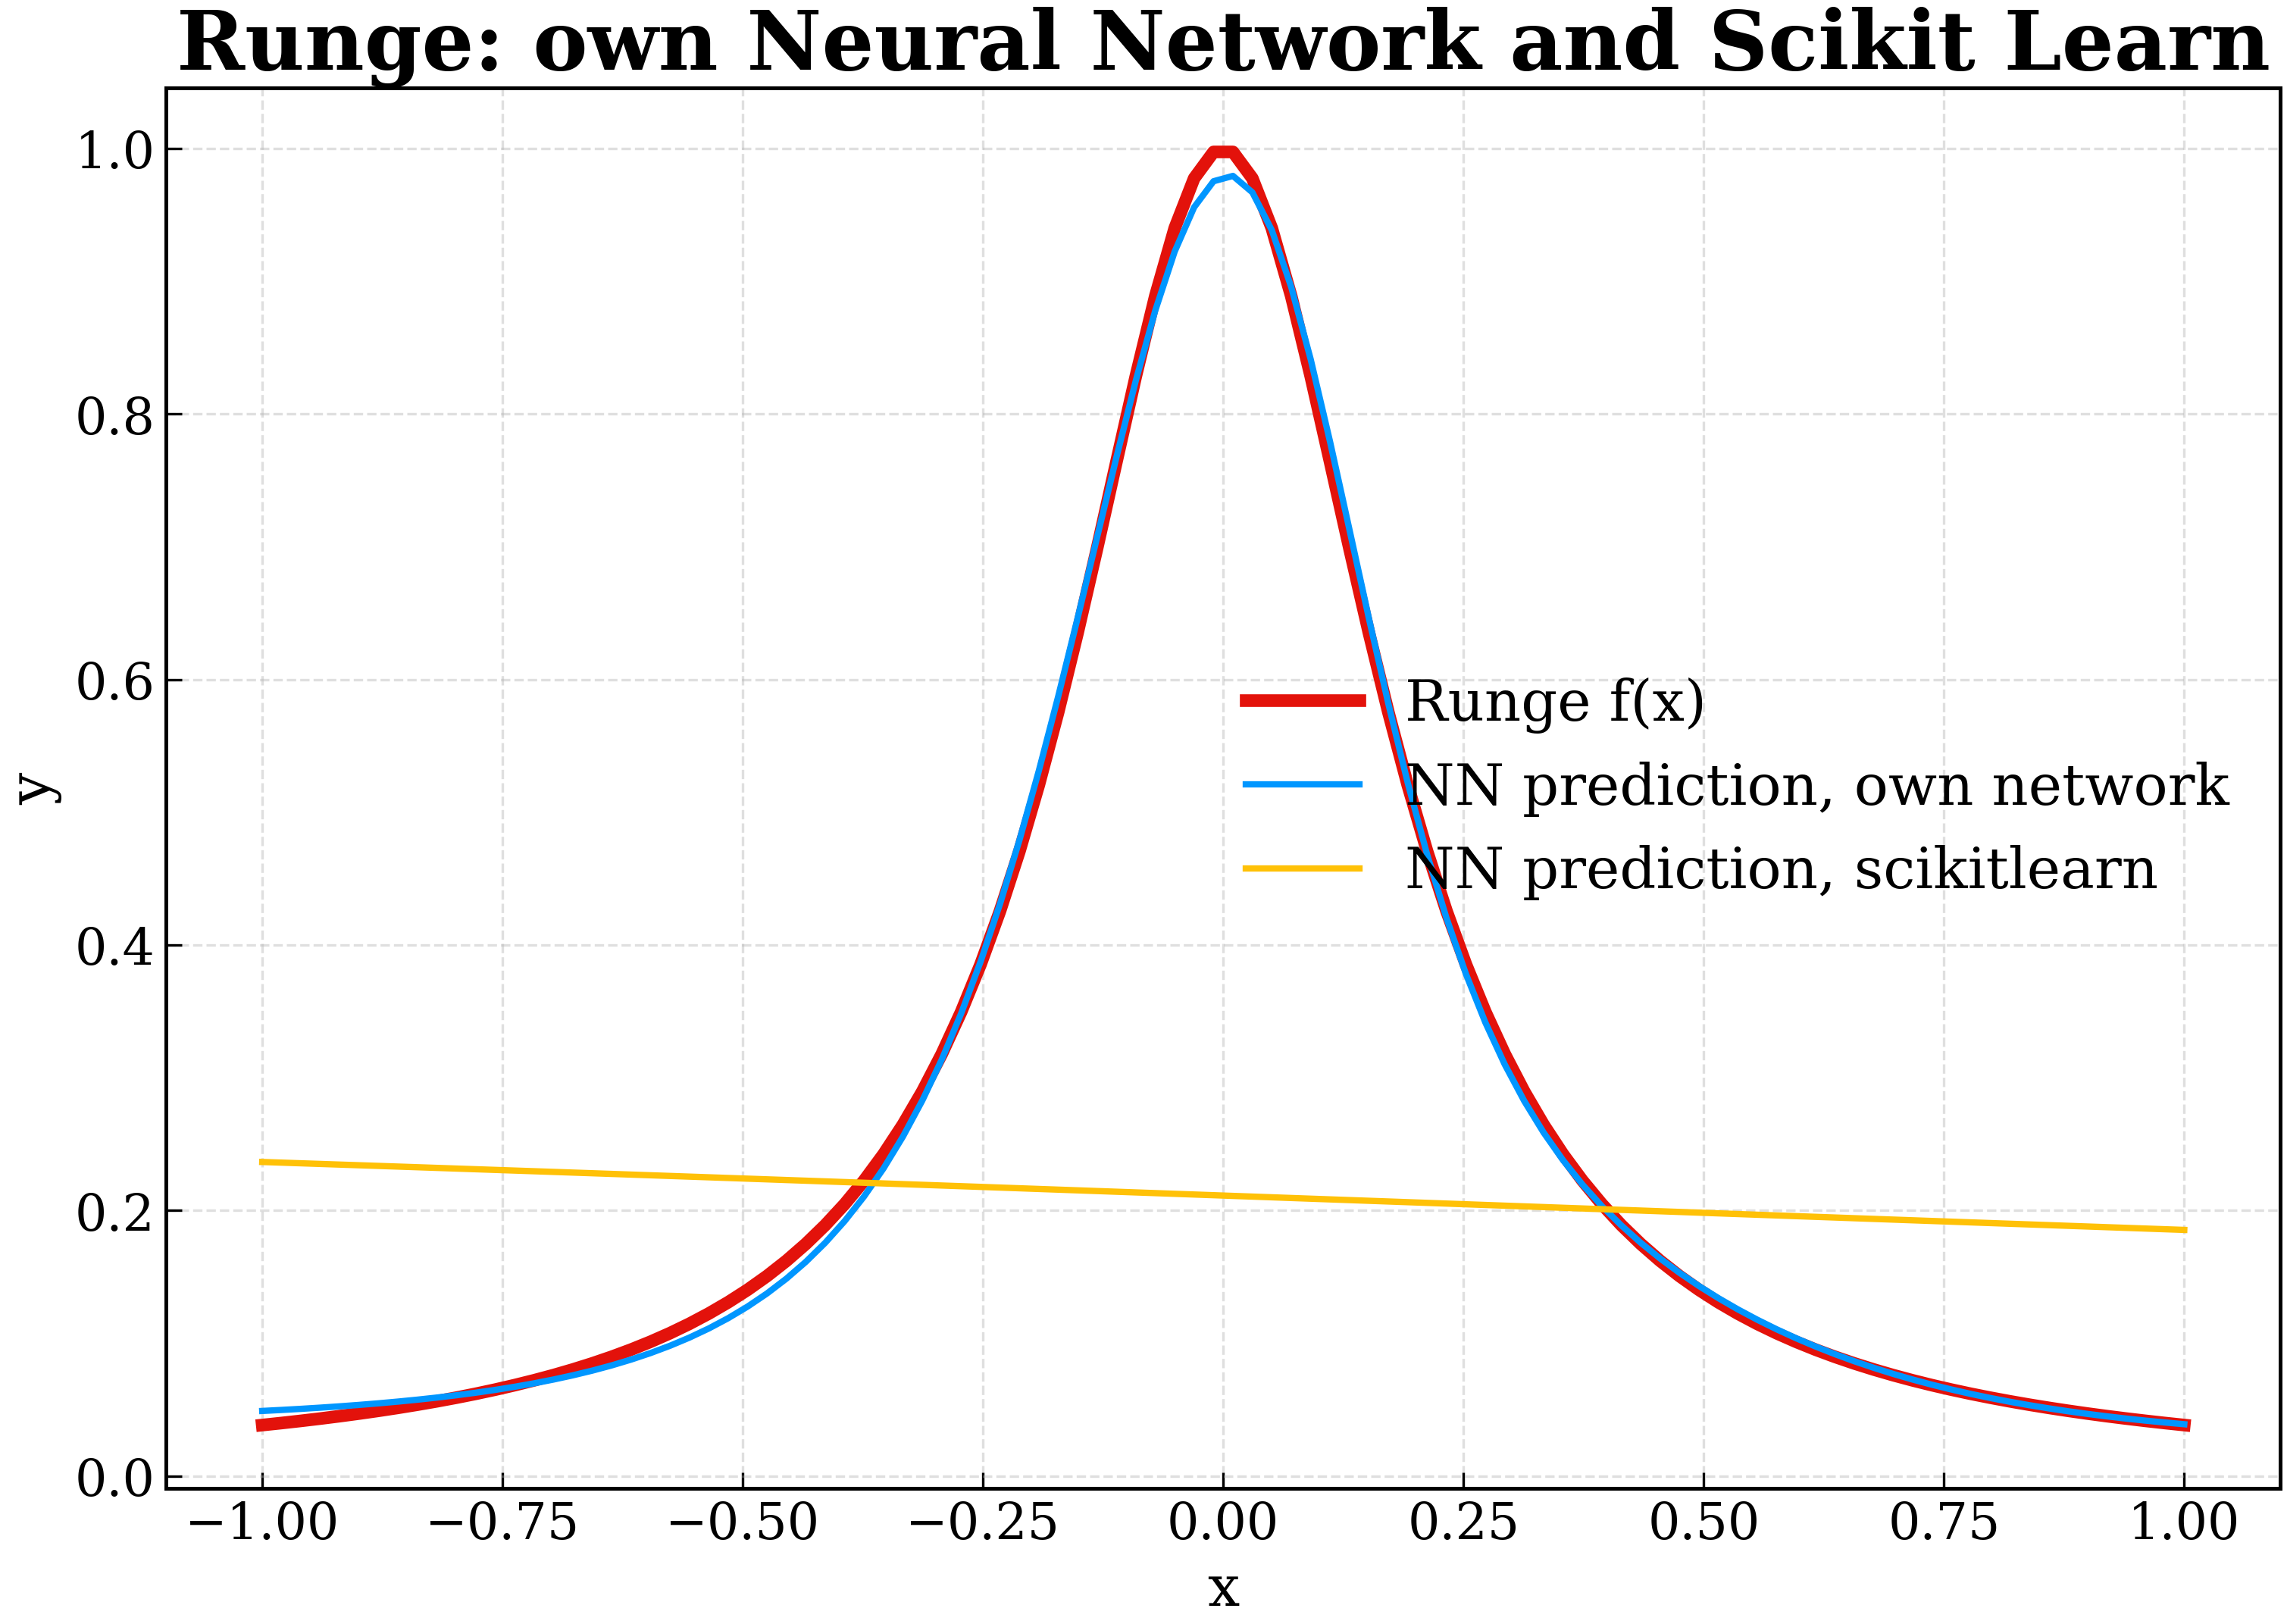

In [8]:
x_s = scaler_x.transform(x)
y_full_own = nn_own.predict(x_s)
y_full_sklearn = nn_sklearn.predict(x_s)

# plt.figure(figsize=(12, 6))
plt.plot(x, y, label="Runge f(x)", linewidth=4)
plt.plot(x, y_full_own, label="NN prediction, own network", linewidth=2)
plt.plot(x, y_full_sklearn, label="NN prediction, scikitlearn", linewidth=2)
# plt.scatter(x_train_unscaled, y_train, color="black", s=15, alpha=0.6, label="Training points")
plt.title("Runge: own Neural Network and Scikit Learn")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

# run by itself then comment out
# plt.savefig("../Plots/Exc_runge_function_regression_nn_scikit.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Comparing different architectures

In [9]:
archs_sklearn = [
    ((10,),        "logistic"),
    ((50,50),      "logistic"),
    ((50,50),      "relu"),
    ((64,64,64),   "relu"),
]

archs_own = [
    ([10, 1],             [sigmoid,           linear], [sigmoid_deriv,           linear_deriv]),
    ([50, 50, 1],         [sigmoid, sigmoid,  linear], [sigmoid_deriv, sigmoid_deriv, linear_deriv]),
    ([50, 50, 1],         [relu,    relu,     linear], [relu_deriv,    relu_deriv,    linear_deriv]),
    ([64, 64, 64, 1],     [relu, relu, relu, linear],  [relu_deriv, relu_deriv, relu_deriv, linear_deriv]),
]

y_preds_sklearn = []
for (layers, act) in archs_sklearn:
    nn_sklearn = MLPRegressor(
        loss='squared_error',
        hidden_layer_sizes=layers,
        activation=act,
        solver='adam',
        alpha=0.0,
        batch_size=batch_size_adam,
        learning_rate_init=lr,    
        max_iter=epochs,
        random_state=seed
    )
    nn_sklearn.fit(x_train, y_train.ravel())
    y_pred_test_sklearn = nn_sklearn.predict(x_test).reshape(-1, 1)
    y_preds_sklearn.append(y_pred_test_sklearn)


y_preds_own = []
for (layer_sizes, acts, ders) in archs_own:
    optimizer = Adam(lr=1e-2)

    nn_own = NeuralNetwork(
        network_input_size=1,  
        layer_output_sizes=layer_sizes,
        activation_funcs=acts,
        activation_ders=ders,
        cost_fun=mse,
        cost_der=mse_deriv,
        seed=seed
    )
    nn_own.fit(
        X=x_train,
        Y=y_train,
        epochs=epochs,
        batch_size=32,
        optimizer=optimizer,
        log_every=None
    )
    y_pred_test_own = nn_own.predict(x_test)
    y_preds_own.append(y_pred_test_own)

# Sammenlign parvis pr arkitektur
print("Comparing with different architectures")
for i in range(len(y_preds_sklearn)):
    y_sk = y_preds_sklearn[i]
    y_own = y_preds_own[i]

    diff = y_own - y_sk
    l2_norm = np.linalg.norm(diff)
    l_inf_norm = np.max(np.abs(diff))
    mean_abs_diff = np.mean(np.abs(diff))

    print(f"Arch {i+1}: sklearn={archs_sklearn[i]}, own={archs_own[i][0]}")
    print(f"  L2-norm = {l2_norm:.3e},  inf-norm = {l_inf_norm:.3e},  mean abs difference = {mean_abs_diff:.3e}")
  


Comparing with different architectures
Arch 1: sklearn=((10,), 'logistic'), own=[10, 1]
  L2-norm = 3.450e-01,  inf-norm = 1.365e-01,  mean abs difference = 6.717e-02
Arch 2: sklearn=((50, 50), 'logistic'), own=[50, 50, 1]
  L2-norm = 1.180e+00,  inf-norm = 7.437e-01,  mean abs difference = 1.980e-01
Arch 3: sklearn=((50, 50), 'relu'), own=[50, 50, 1]
  L2-norm = 8.819e-02,  inf-norm = 4.077e-02,  mean abs difference = 1.613e-02
Arch 4: sklearn=((64, 64, 64), 'relu'), own=[64, 64, 64, 1]
  L2-norm = 4.819e-02,  inf-norm = 2.409e-02,  mean abs difference = 8.558e-03


## Testing Derivatives with Autograd

### Importing autograd

In [10]:
import autograd.numpy as anp
from autograd import grad

### Autograd check, 50-50-1 sigmoid-sigmoid-linear

In [11]:
# 1) choose data
X = x_train.astype(np.float64)
Y = y_train.astype(np.float64)

# 2) build network
layer_output_sizes = [50, 50, 1]
activation_funcs   = [sigmoid, sigmoid, linear]
activation_ders    = [sigmoid_deriv, sigmoid_deriv, linear_deriv]
nn = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=layer_output_sizes,
    activation_funcs=activation_funcs,
    activation_ders=activation_ders,
    cost_fun=mse,           
    cost_der=mse_deriv,     
    seed=6114
)



# 3) Fetch params from network, format paramters to fit Autograd
params = []
for (W, b) in nn.layers:
    W64 = W.astype(np.float64).copy()
    b64 = b.astype(np.float64).reshape(-1).copy()  # bias som 1D-vektor
    params.append((W64, b64))

# 4) Explicit forward pass with autograd.numpy
def a_sigmoid(z):
    return 1.0 / (1.0 + anp.exp(-z))

def a_linear(z):
    return z

# Activation names for each layer
act_names = ["sigmoid", "sigmoid", "linear"]

def forward_autograd(X, params, act_names):
    a = X
    for (W, b), name in zip(params, act_names):
        z = anp.dot(a, W) + b
        if name == "sigmoid":
            a = a_sigmoid(z)
        elif name == "linear":
            a = a_linear(z)
        else:
            raise ValueError("Unknown activation function")
    return a

# 5) Loss function for autograd
def loss_autograd(params, X, Y, act_names):
    Yhat = forward_autograd(X, params, act_names)
    return anp.mean((Yhat - Y)**2)

# 6) Make autograd function that gives gradiendts of loss wrt params
grad_fn = grad(loss_autograd)  

# 7) Autograd-gradients
ag_grads = grad_fn(params, X, Y, act_names)   # list of (dW_ag, db_ag)

# 8) Our own gradients
my_grads = nn.compute_gradient(X, Y)          # list of (dW, db)
# Make sure that db is 1D
my_grads = [(dW, db.reshape(-1)) for (dW, db) in my_grads]

# 9) Comparison, layer by layer
print("Gradient comparison (own backprop vs Autograd)")
total_sq = 0.0
for i in range(len(my_grads)):
    dW_me, db_me = my_grads[i]
    dW_ag, db_ag = ag_grads[i]

    dW_diff = dW_me - dW_ag
    db_diff = db_me - db_ag

    W_L2   = np.linalg.norm(dW_diff)
    b_L2   = np.linalg.norm(db_diff)
    W_Linf = np.max(np.abs(dW_diff))
    b_Linf = np.max(np.abs(db_diff))

    total_sq += np.sum(dW_diff**2) + np.sum(db_diff**2)
    print(f"Layer {i}: ")
    print(f"L2 norm diff, weights={W_L2:.3e}")
    print(f"L2 norm diff, bias={b_L2:.3e}")
    print(f"inf norm diff, weights={W_Linf:.3e}")
    print(f"inf norm diff, bias={b_Linf:.3e}")

total_L2 = float(np.sqrt(total_sq))
print(f"Total gradient L2-norm difference: {total_L2:.3e}")



Gradient comparison (own backprop vs Autograd)
Layer 0: 
L2 norm diff, weights=4.260e-21
L2 norm diff, bias=2.625e-20
inf norm diff, weights=2.541e-21
inf norm diff, bias=1.355e-20
Layer 1: 
L2 norm diff, weights=4.979e-18
L2 norm diff, bias=8.813e-19
inf norm diff, weights=1.301e-18
inf norm diff, bias=4.337e-19
Layer 2: 
L2 norm diff, weights=1.923e-16
L2 norm diff, bias=0.000e+00
inf norm diff, weights=5.551e-17
inf norm diff, bias=0.000e+00
Total gradient L2-norm difference: 1.924e-16


### Autograd check: 20-20-20-1, relu-relu-relu-linear

In [12]:
# 1) choose data
X = x_train.astype(np.float64)
Y = y_train.astype(np.float64)

# 2) build network
layer_output_sizes = [20, 20, 20, 1]
activation_funcs = [relu, relu, relu, linear]
activation_ders  = [relu_deriv, relu_deriv, relu_deriv, linear_deriv]

nn = NeuralNetwork(
    network_input_size=1,
    layer_output_sizes=layer_output_sizes,
    activation_funcs=activation_funcs,
    activation_ders=activation_ders,
    cost_fun=mse,           
    cost_der=mse_deriv,     
    seed=6114
)



# 3) Fetch params from network, format paramters to fit Autograd
params = []
for (W, b) in nn.layers:
    W64 = W.astype(np.float64).copy()
    b64 = b.astype(np.float64).reshape(-1).copy()  # bias som 1D-vektor
    params.append((W64, b64))

# 4) Explicit forward pass with autograd.numpy
def a_relu(z):    
    return anp.maximum(0.0, z)
def a_linear(z):  
    return z

# Activation names for each layer
act_names = ["relu", "relu", "relu", "linear"]

def forward_autograd(X, params, act_names):
    a = X
    for (W, b), name in zip(params, act_names):
        z = anp.dot(a, W) + b
        if name == "relu":
            a = a_relu(z)
        elif name == "linear":
            a = a_linear(z)
        else:
            raise ValueError("Unknown activation function")
    return a

# 5) Loss function for autograd
def loss_autograd(params, X, Y, act_names):
    Yhat = forward_autograd(X, params, act_names)
    return anp.mean((Yhat - Y)**2)

# 6) Make autograd function that gives gradiendts of loss wrt params
grad_fn = grad(loss_autograd)  

# 7) Autograd-gradients
ag_grads = grad_fn(params, X, Y, act_names)   # list of (dW_ag, db_ag)

# 8) Our own gradients
my_grads = nn.compute_gradient(X, Y)          # list of (dW, db)
# Make sure that db is 1D
my_grads = [(dW, db.reshape(-1)) for (dW, db) in my_grads]

# 9) Comparison, layer by layer
print("Gradient comparison (own backprop vs Autograd)")
total_sq = 0.0
for i in range(len(my_grads)):
    dW_me, db_me = my_grads[i]
    dW_ag, db_ag = ag_grads[i]

    dW_diff = dW_me - dW_ag
    db_diff = db_me - db_ag

    W_L2   = np.linalg.norm(dW_diff)
    b_L2   = np.linalg.norm(db_diff)
    W_Linf = np.max(np.abs(dW_diff))
    b_Linf = np.max(np.abs(db_diff))

    total_sq += np.sum(dW_diff**2) + np.sum(db_diff**2)
    print(f"Layer {i}: ")
    print(f"L2 norm diff, weights={W_L2:.3e}")
    print(f"L2 norm diff, bias={b_L2:.3e}")
    print(f"inf norm diff, weights={W_Linf:.3e}")
    print(f"inf norm diff, bias={b_Linf:.3e}")

total_L2 = float(np.sqrt(total_sq))
print(f"Total gradient L2-norm difference: {total_L2:.3e}")



Gradient comparison (own backprop vs Autograd)
Layer 0: 
L2 norm diff, weights=0.000e+00
L2 norm diff, bias=0.000e+00
inf norm diff, weights=0.000e+00
inf norm diff, bias=0.000e+00
Layer 1: 
L2 norm diff, weights=0.000e+00
L2 norm diff, bias=0.000e+00
inf norm diff, weights=0.000e+00
inf norm diff, bias=0.000e+00
Layer 2: 
L2 norm diff, weights=0.000e+00
L2 norm diff, bias=0.000e+00
inf norm diff, weights=0.000e+00
inf norm diff, bias=0.000e+00
Layer 3: 
L2 norm diff, weights=0.000e+00
L2 norm diff, bias=0.000e+00
inf norm diff, weights=0.000e+00
inf norm diff, bias=0.000e+00
Total gradient L2-norm difference: 0.000e+00


In [13]:
### Sanity-test:
# Sjekk bit-for-bit likhet
for i, ((dW_m, db_m), (dW_a, db_a)) in enumerate(zip(my_grads, ag_grads)):
    print(f"Layer {i}: W equal? {np.array_equal(dW_m, dW_a)} | b equal? {np.array_equal(db_m, db_a)}")

# Eller skriv ut maksimal absoluttavvik med høy presisjon
for i, ((dW_m, db_m), (dW_a, db_a)) in enumerate(zip(my_grads, ag_grads)):
    maxW = np.max(np.abs(dW_m - dW_a))
    maxb = np.max(np.abs(db_m - db_a))
    print(f"Layer {i}: max|ΔW| = {maxW:.16e}, max|Δb| = {maxb:.16e}")


Layer 0: W equal? True | b equal? True
Layer 1: W equal? True | b equal? True
Layer 2: W equal? True | b equal? True
Layer 3: W equal? True | b equal? True
Layer 0: max|ΔW| = 0.0000000000000000e+00, max|Δb| = 0.0000000000000000e+00
Layer 1: max|ΔW| = 0.0000000000000000e+00, max|Δb| = 0.0000000000000000e+00
Layer 2: max|ΔW| = 0.0000000000000000e+00, max|Δb| = 0.0000000000000000e+00
Layer 3: max|ΔW| = 0.0000000000000000e+00, max|Δb| = 0.0000000000000000e+00
